In [248]:
import pandas as pd
import numpy as np
import pyannote.audio
import librosa
import matplotlib.pyplot as plt
import librosa.display
import os
from pandas.api.types import CategoricalDtype


In [166]:
fname = '../data/raw/z-c-feisty.wav'
x, sr = librosa.load(fname)
#!ffmpeg -i ../data/raw/z-c-feisty.wav ../data/processed/z-c-feisty.mp3 

In [167]:
fname_rttm = '../data/processed/test.rttm'
speaker_track = pd.read_csv(fname_rttm,header=None,delim_whitespace=True,
            names = ['x1','filename','fileid','start','duration','skip1','skip2','speaker_id','skip3'])
speaker_track['end'] = speaker_track['start']+speaker_track['duration']
bins_speaker = pd.DataFrame({'name':speaker_track['speaker_id'].values},index = pd.IntervalIndex.from_arrays(left = speaker_track['start'],right=speaker_track['end']))
speaker_track.drop(['skip1','skip2','skip3'],axis=1,inplace = True)
speaker_track.head(2)
cat_type = CategoricalDtype(categories=speaker_track['speaker_id'].unique().tolist())


,x1,filename,fileid,start,duration,speaker_id,end
0,SPEAKER,z-c-feisty,1,0.07,0.21,speaker2,0.28
1,SPEAKER,z-c-feisty,1,0.28,0.08,speaker1,0.36


In [250]:
#librosa.output.write_wav('../data/raw/z-c-feisty.mp3', x, sr)
df = pd.DataFrame({"time":np.arange(x.shape[0])/sr,"amplitude":x})


In [252]:
def find_speaker(x):
    try:
        res =bins_speaker.loc[x,'name'].values[0]
    except:
        res=np.nan
    return res
#t = tmp.reset_index()
tmp = df.sample(frac=0.005).sort_values('time')
speaker_id = tmp['time'].apply(lambda x: find_speaker(x))
speaker_id.head()
tmp['speaker']  =speaker_id.astype(cat_type)
tmp.set_index('time',inplace=True,drop=False)

0.0
34.0
68.0
102.0
135.0
169.0
203.0
237.0
271.0
305.0
338.0


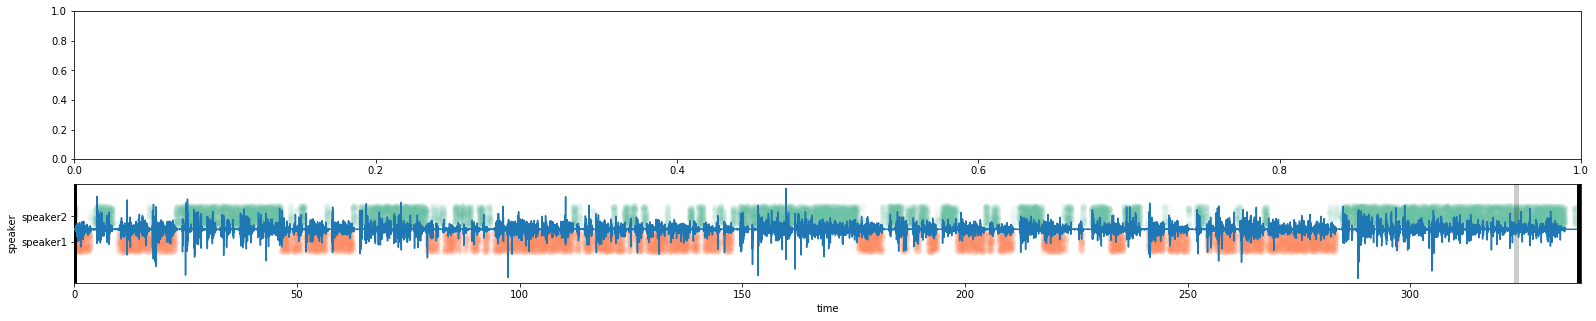

In [269]:
import seaborn as sns
folder_output =os.path.splitext(fname)[0]
os.makedirs(folder_output,exist_ok=True)
fig,ax = plt.subplots(figsize=(27, 5),nrows=2,gridspec_kw = {'height_ratios':[3,2]})
tmp['speaker_cat'] = tmp['speaker'].cat.codes
tmp.loc[tmp['speaker_cat'] == -1,'speaker_cat'] = np.NaN
sns.stripplot(x='time',y='speaker',data= tmp,ax=ax[1],alpha=0.05,palette='Set2',jitter = 0.4,size=6.5,zorder=0)
tmp['amp_scaled'] = np.mean(ax[1].get_ylim())+tmp['amplitude']*len(tmp['speaker'].unique())

tmp['amp_scaled'].plot(ax=ax[1],zorder=10)
sec=0
dsec= 15
line = ax[1].axvline(sec,c = 'k',linewidth=5)
line = ax[1].axvline(sec,c = 'k',linewidth=5)
line_l = ax[1].axvline(sec-dsec*0.95,c = 'k',alpha=0.2,linewidth=5)
line_r = ax[1].axvline(sec+dsec*0.95,c = 'k',alpha=0.2,linewidth=5)

line_top_panel = ax[0].axvline(sec,c = 'k',linewidth=5)
sub_tmp = tmp[(tmp.index>sec-dsec) & (tmp.index<sec+dsec)]
n_frames = 10
sec_per_frame = (df['time'].max()+1) / n_frames
ax[1].set_xlim([0,df['time'].max()+1])

for fr in np.arange(n_frames+1):
    sec = np.round(fr * sec_per_frame)
    sub_tmp = tmp[(tmp.index>sec-dsec) & (tmp.index<sec+dsec)].copy()
    sns.stripplot(x='time',y='speaker',data= sub_tmp,ax=ax[0],alpha=0.5,palette='Set2',jitter = 0.3,size=7.5,zorder=0)
    sub_tmp['amp_scaled'] = sub_tmp['speaker_cat']+sub_tmp['amplitude'] * sub_tmp['speaker_cat'].unique().shape[0]
    sub_tmp['amp_scaled'].plot(ax=ax[0],zorder=10)
    
    line_top_panel = ax[0].axvline(sec,c = 'k',linewidth=5)
    fig_name = os.path.join(folder_output,f'{sec}.png')
    line.set_xdata([sec,sec])
    line_l.set_xdata(sec-dsec*0.95)
    line_r.set_xdata(sec+dsec*0.95)
    fig.savefig(fig_name)
    ax[0].clear()
    print(sec)

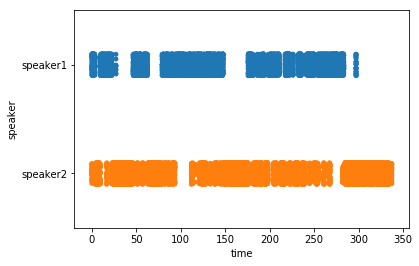

In [219]:
sub_tmp = tmp[(tmp.index>sec-dsec) & (tmp.index<sec+dsec)]
sub_tmp

,amplitude,speaker,speaker_cat
time,,,


time
0.004354           NaN
0.005351           NaN
0.014150           NaN
0.020091           NaN
0.035601           NaN
0.041723           NaN
0.044082           NaN
0.054694           NaN
0.066667           NaN
0.084218      speaker2
0.106848      speaker2
0.110431      speaker2
0.114785      speaker2
0.118730      speaker2
0.120408      speaker2
0.122948      speaker2
0.133968      speaker2
0.135828      speaker2
0.140000      speaker2
0.150930      speaker2
0.166077      speaker2
0.168073      speaker2
0.173469      speaker2
0.175238      speaker2
0.177143      speaker2
0.205215      speaker2
0.211565      speaker2
0.213333      speaker2
0.215011      speaker2
0.218639      speaker2
                ...   
337.080408    speaker2
337.081406    speaker2
337.087891    speaker2
337.106757    speaker2
337.117007    speaker2
337.137415    speaker2
337.140181    speaker2
337.148254    speaker2
337.156281    speaker2
337.156871    speaker2
337.158594    speaker2
337.161451    speaker2
337.16